In [1]:
import seaborn 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from utils.preprocessing import preprocessing 
from utils.utils import feature_importances,initial_hyperparam_search,cast_params_to_proper_types,lgb_f1_score
import seaborn as sns
from matplotlib import pyplot 

In [3]:
prepos= preprocessing()

In [4]:
df_org_data = prepos.read_data("creditcard.csv")

##### EDA and Corelations with target variable

<AxesSubplot: >

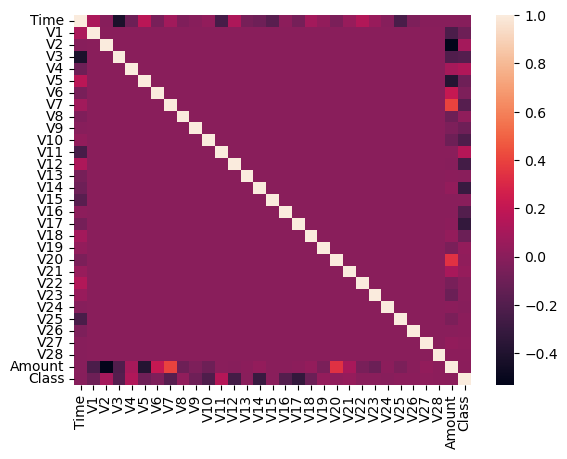

In [5]:
df_org_data.Class.value_counts()
corr = df_org_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [6]:
X_train,X_test,y_train,y_test=train_test_split(df_org_data,df_org_data["Class"],test_size=0.2,random_state=42,stratify=df_org_data["Class"])

X_train,X_val,y_train,y_val=train_test_split(X_train,X_train["Class"],test_size=0.2,random_state=42,stratify=X_train["Class"])

##### feature importances

In [7]:
# fimp=feature_importances()
# X_train_feature_selection, accepted_columns,assoc_result,disallowed_columns = fimp.filter_out_features_based_on_statistical_approach(X_train,[],"Class")
# accepted_columns.append("Amount")
# X_train_feature_selection["Amount"]=X_train["Amount"]

In [8]:
X_train_feature_selection=X_train.drop(["Class"],axis=1)
# X_val_feature_selection=X_val.drop(["Class"],axis=1)

In [9]:
from functools import partial
from typing import Dict

import pandas as pd
import numpy as np

from dython.nominal import associations

from hyperopt import tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score

import lightgbm as lgb

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin

In [10]:
params_scope = {
    'learning_rate': hp.uniform('learning_rate', 0.00001, 0.1),
    'num_leaves': hp.quniform('num_leaves', 2, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 100, 10),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 100, 1000, 50),
    #'reg_alpha': hp.uniform('reg_alpha', 0.00, 10.0),
    'reg_lambda ': hp.uniform('reg_lambda', 10.00, 100.0),
    'pos_bagging_fraction': hp.uniform('pos_bagging_fraction', 0.0, 1.0),
    'max_bin': hp.quniform('max_bin', 16, 256, 16),
    'num_boost_round':10
}


import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    initial_params = initial_hyperparam_search(X_train_feature_selection, y_train, X_val[X_train_feature_selection.columns], y_val, params_scope)


# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     to_keep, n_features, scores_per_features = perform_rfe(
#         X_train_feature_selection,
#         y_train,
#         X_val_feature_selection[X_train_feature_selection.columns],
#         y_val,
#         cast_params_to_proper_types(initial_params),
#         minimal_importance=0.01,
#         minimal_amount_of_features_to_keep=10,
#         n_repeats=15,
#     )


100%|███████████████████████████████████████████████████████| 250/250 [1:49:25<00:00, 26.26s/trial, best loss: 0.34375]


In [11]:
initial_params

{'learning_rate': 0.009727381256918854,
 'max_bin': 32.0,
 'n_estimators': 50.0,
 'num_leaves': 6.0,
 'pos_bagging_fraction': 0.8207550005048259,
 'reg_lambda': 36.764639371610755,
 'scale_pos_weight': 200.0}

In [12]:
params = cast_params_to_proper_types(initial_params)
model = lgb.LGBMClassifier(
        random_state=42,
        verbose=-1,
        objective='binary'
        ,**params
)

In [13]:

model.fit(
    X_train_feature_selection,
    y_train,
    eval_set=[(X_val[X_train_feature_selection.columns], y_val)],
    verbose=0,
    eval_metric=lgb_f1_score
)

# model.feature_importances

C:\Users\vishalra\Anaconda3\envs\fraud_detection\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(learning_rate=0.009727381256918854, max_bin=32, n_estimators=50,
               num_leaves=6, objective='binary', random_state=42,
               scale_pos_weight=200, verbose=-1)

In [15]:
model.feature_importances_

array([10,  3,  5, 17, 43,  3,  1, 13,  5,  6,  3,  8, 16, 11, 34,  1,  3,
        8,  3,  7,  6,  3,  2,  0,  0,  5, 12,  3,  0, 19])

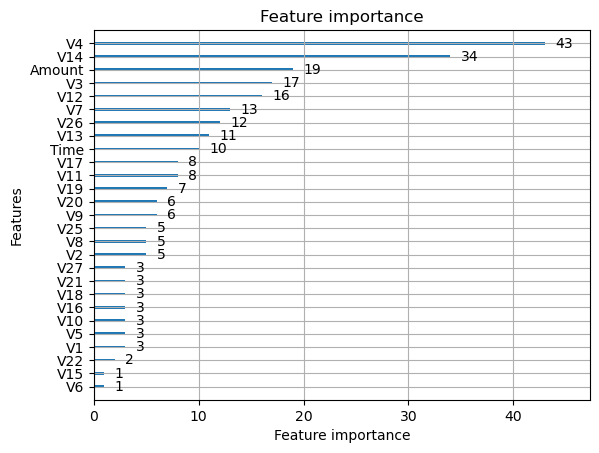

In [14]:
from lightgbm import plot_importance
plot_importance(model)
pyplot.show()

In [ ]:
X_train.drop(["Class"],axis=1,inplace=True)

In [ ]:
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val[X_train.columns], y_val)],
    verbose=0,
    eval_metric=lgb_f1_score
)

In [ ]:
from lightgbm import plot_importance
plot_importance(model)
pyplot.show()